**PART 1**

In [1]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.3 MB/s eta 0:00:00


In [2]:
# This is a sample Python script.
import torch
# Press Umschalt+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from collections import Counter

# Mappings
label_mapping = {"O": 0, "LOC": 1, "PER": 2, "ORG": 3}


class NERDataset(Dataset):
    def __init__(self, tokenized_data):
        self.my_tokenized_data = tokenized_data

    def __len__(self):
        return len(self.my_tokenized_data)

    def __getitem__(self, idx):
        item = self.my_tokenized_data[idx]
        tensorized_item = {}
        for key, val in item.items():
            tensorized_item[key] = torch.tensor(val)
        return tensorized_item


def tokenize_and_align_labels(tokenizer, words, ner_labels):
    tokenized_inputs = tokenizer(words, truncation=True, padding='max_length', is_split_into_words=True)

    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)  # Special token
        elif word_idx != previous_word_idx:
            label_str = ner_labels[word_idx]
            label_num = label_mapping[label_str]
            label_ids.append(label_num)
        else:
            label_ids.append(-100)  # Word is split into subtokens
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs



**Get the polyglot Data**

In [3]:
import glob
import json

# Path to where data lies
folder_path = '/content'

# Pattern of file names
file_pattern = 'polyglot_ner_fr_train_*.json'

# Complete Path with pattern
full_path = f'{folder_path}/{file_pattern}'

# List where data will be saved
all_data = []

# process to read data
for file_path in glob.glob(full_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        for row in data['rows']:
            all_data.append(row['row'])

print(all_data[:5])
print("Lenght of data is: "+str(len(all_data)))


[{'id': '3100', 'lang': 'fr', 'words': ['Les', 'Bulles', 'viendrait', 'de', '«', 'bûle', '»', 'ou', '«', 'bûre', '»,', 'qui', 'désigne', 'en', 'ancien', 'français', 'une', 'hutte', ',', 'un', 'grand', 'tas', 'conique', 'ou', 'carré', 'de', 'branches', ',', 'assez', 'haut', 'et', 'destiné', 'à', 'être', 'brûlé', '(', 'Jean', 'Haust', ').'], 'ner': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PER', 'PER', 'O']}, {'id': '3101', 'lang': 'fr', 'words': ['la', 'même', 'année', ',', 'un', 'cirque', 'est', 'construit', 'sur', 'la', 'place', 'de', "l'Abreuvoir", '(', "l'actuelle", 'place', 'du', 'Cirque', '),', 'à', "l'angle", 'de', 'la', 'rue', 'de', "l'Arche", '-', 'Sèche', '.'], 'ner': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, {'id': '3102', 'lang': 'fr

**Explorative Data Analysis**

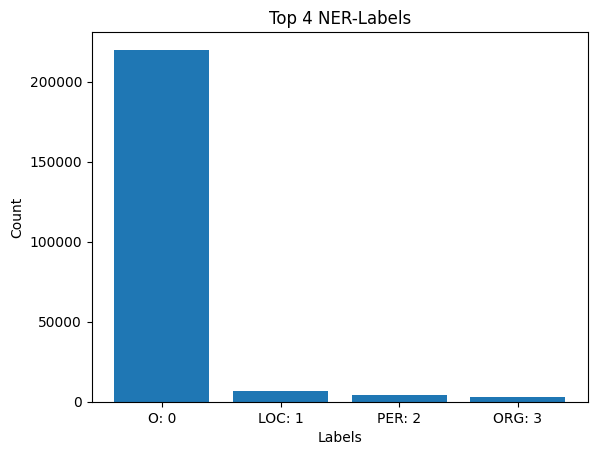

In [4]:
label_counts = Counter()
for item in all_data:
        ner_labels = item['ner']
        label_counts.update(ner_labels)

#Choosing top 5 labels
most_common_labels = label_counts.most_common(5)

#Preparing Data for Diagram
labels, counts = zip(*most_common_labels)

labels = [f'{label}: {label_mapping[label]}' for label in labels]

#Creating bar chart
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Top 4 NER-Labels')
plt.show()


**Train Models**

In [5]:
from transformers import EvalPrediction
from sklearn.metrics import f1_score, precision_recall_fscore_support
def compute_metrics(p: EvalPrediction):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=2)

    # Entfernen Sie Ignored-Token (-100) und wandeln Sie die numerischen IDs in Labels um
    true_labels = [[label_mapping.get(l, l) for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_mapping.get(p, p) for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]


    # Berechnen Sie F1-Scores
    true_labels_flat = [l for sublist in true_labels for l in sublist]
    true_predictions_flat = [p for sublist in true_predictions for p in sublist]

    f1_micro = f1_score(true_labels_flat, true_predictions_flat, average='micro')
    f1_macro = f1_score(true_labels_flat, true_predictions_flat, average='macro')

    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [6]:
# Press the green button in the gutter to run the script.
def trainModel(all_data, frozen_embeddings):
    tokenized_datasets = []
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
    for item in all_data:
        words = item['words']
        ner_labels = item['ner']
        tokenized_data = tokenize_and_align_labels(tokenizer, words, ner_labels)
        tokenized_datasets.append(tokenized_data)

    # Aufteilen in Trainings- und Evaluierungsdaten
    train_data, eval_data = train_test_split(tokenized_datasets, test_size=0.2)

    model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=4)

    if frozen_embeddings:
        for param in model.bert.embeddings.parameters():
            param.requires_grad = False
    training_args = TrainingArguments(
        output_dir='./results',  # Ausgabeverzeichnis
        num_train_epochs=3,  # Anzahl der Trainingsepochen
        per_device_train_batch_size=8,  # Batch-Größe pro Gerät beim Training
        per_device_eval_batch_size=8,  # Batch-Größe pro Gerät bei der Bewertung
        warmup_steps=500,  # Anzahl der Aufwärm-Schritte für den Lernratenplaner
        weight_decay=0.01,  # Gewichtsverfall, falls angewendet
        logging_dir='./logs',  # Verzeichnis für Protokolldateien
        logging_steps=10,
    )

    train = NERDataset(train_data)
    eval = NERDataset(eval_data)
    trainer = Trainer(
        model=model,  # The trained Model
        args=training_args,  # Trainingsarguments
        train_dataset=train,  # Trainingsdata
        eval_dataset=eval,  # Evaluationdata
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer

In [7]:
model=trainModel(all_data[:1000], False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.404100
20,1.144600
30,0.734500
40,0.370700
50,0.251100
60,0.310500
70,0.177900
80,0.184900
90,0.159400
100,0.152800


In [8]:
import numpy as np
model.evaluate()

{'eval_loss': 0.10523298382759094,
 'eval_f1_micro': 0.9564681724845996,
 'eval_f1_macro': 0.6351189098363828,
 'eval_runtime': 1.9246,
 'eval_samples_per_second': 103.916,
 'eval_steps_per_second': 2.078,
 'epoch': 3.0}

In [7]:
model2=trainModel(all_data[:3000], False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.202900
20,1.016000
30,0.624300
40,0.320600
50,0.298600
60,0.342500
70,0.265900
80,0.207200
90,0.219300
100,0.161800


In [9]:
import numpy as np
model2.evaluate()

{'eval_loss': 0.0981544703245163,
 'eval_f1_micro': 0.9643037426984928,
 'eval_f1_macro': 0.7414053035339611,
 'eval_runtime': 20.3212,
 'eval_samples_per_second': 29.526,
 'eval_steps_per_second': 3.691,
 'epoch': 3.0}

In [10]:
model3=trainModel(all_data[:3000], True)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.416400
20,1.213800
30,0.816300
40,0.417700
50,0.342800
60,0.264400
70,0.264000
80,0.175900
90,0.213700
100,0.191300


In [11]:
import numpy as np
model3.evaluate()

{'eval_loss': 0.09518144279718399,
 'eval_f1_micro': 0.9617048436281115,
 'eval_f1_macro': 0.7513784810993189,
 'eval_runtime': 19.753,
 'eval_samples_per_second': 30.375,
 'eval_steps_per_second': 3.797,
 'epoch': 3.0}